### Evaluating Regression Models

Data:<br> 
Allstate Claims Severity<br>
https://www.kaggle.com/c/allstate-claims-severity

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_validate
import warnings
sns.set_theme()

In [2]:
# save selected figures for report
savefig = True
fig_path = 'figs/'
if savefig:
    os.makedirs(fig_path, exist_ok=True) 

### Data preparation, exploration, visualization

In [3]:
# overview of training data
train = pd.read_csv('train.csv', index_col='id')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188318 entries, 1 to 587633
Columns: 131 entries, cat1 to loss
dtypes: float64(15), object(116)
memory usage: 189.7+ MB


In [4]:
# confirm that id is unique
train.index.nunique()==len(train)

True

In [5]:
# no missing values and no duplicated rows
print(f'Number of missing values = {train.isna().sum().sum()}')
print(f'Number of duplicate rows (all duplicates): {train.duplicated(keep=False).sum()}')

Number of missing values = 0
Number of duplicate rows (all duplicates): 0


In [6]:
# categorical and continuous variables in training data
# this information was provided by Allstate 
cat_cols = train.columns[train.columns.str.startswith('cat')].tolist()
num_cols = train.columns[train.columns.str.startswith('cont')].tolist()
print(f'There are {len(cat_cols)} categorical and {len(num_cols)} continuous columns')

There are 116 categorical and 14 continuous columns


In [7]:
# descriptive/summary stats on continuous columns in training data
# continuous variables appear to have been preprocessed and are similarly scaled between [0,1]
train.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [8]:
# examine min and max values for individual continuous variables
# (although similarly scaled, not all have min of 0 and max of 1)
print('\nmin and max of minimum values')
print(train.describe().iloc[:,:-1].loc['min'].agg(['min', 'max']).round(2))
print('\nmin and max of maximum values')
print(train.describe().iloc[:,:-1].loc['max'].agg(['min', 'max']).round(2))


min and max of minimum values
min    0.00
max    0.28
Name: min, dtype: float64

min and max of maximum values
min    0.84
max    1.00
Name: max, dtype: float64


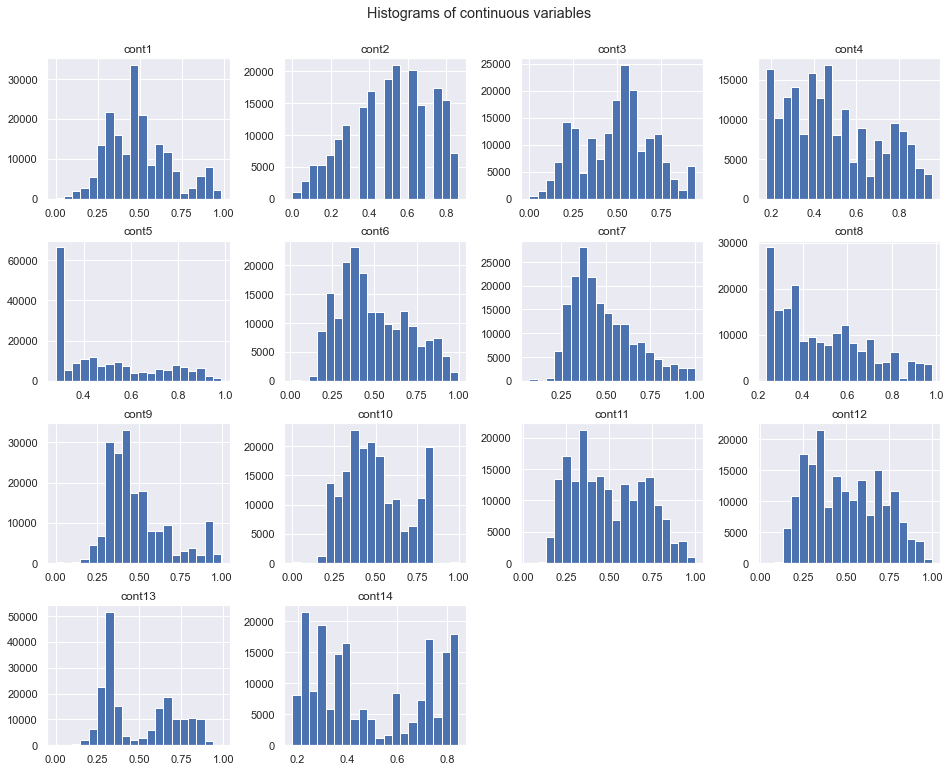

In [9]:
# examine distributions of continuous variables
train[num_cols].hist(figsize=(16, 12), bins=20)
plt.suptitle('Histograms of continuous variables')
plt.subplots_adjust(top=0.92)
if savefig:
    plt.savefig(fig_path+'cont_hist.pdf', format='pdf', bbox_inches='tight')

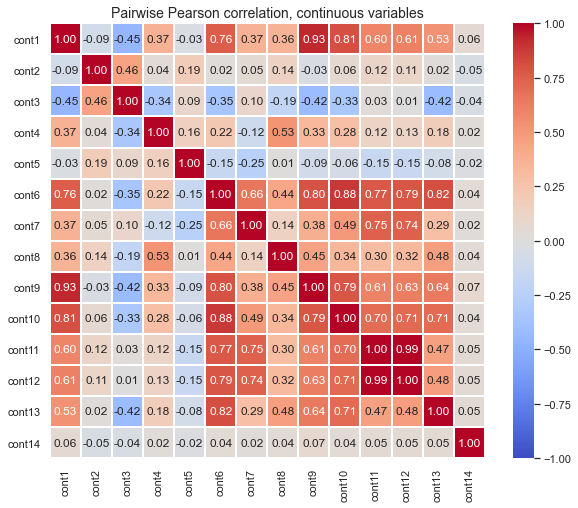

cont11  cont12    0.994384
cont1   cont9     0.929912
cont6   cont10    0.883351
        cont13    0.815091
cont1   cont10    0.808551
dtype: float64

In [10]:
# pairwise pearson correlation of continuous variables
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(train[num_cols].corr(), cmap='coolwarm', square=True, 
            lw=1, vmin=-1, vmax=1, annot=True, fmt='.2f', ax=ax)
ax.set_title('Pairwise Pearson correlation, continuous variables', fontsize=14)
plt.show()
if savefig:
    fig.savefig(fig_path+'heatmap.pdf', format='pdf', bbox_inches='tight')

# pairs with Pearson r > 0.8
cc = train[num_cols].corr().abs()
cc_list = cc.where(np.triu(np.ones(cc.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False)
cc_list[(cc_list>0.8)]

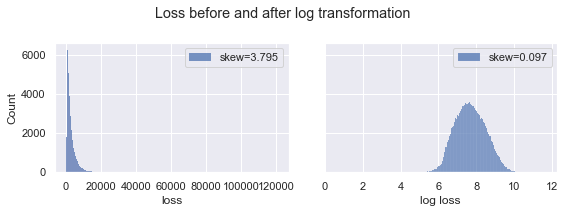

In [11]:
# the target variable loss looks heavily skewed; less skewed after log transformation 
fig, axs = plt.subplots(1,2, figsize=(8,3), sharey=True)
sns.histplot(train['loss'],
             label='skew={:.3f}'.format(train['loss'].skew()), ax=axs[0])
sns.histplot(np.log1p(train['loss']),
             label='skew={:.3f}'.format(np.log1p(train['loss']).skew()), ax=axs[1])
axs[1].set_xlabel('log loss')
for ax in axs:
    ax.legend()
plt.suptitle('Loss before and after log transformation')
fig.tight_layout()
plt.show()
if savefig:
    fig.savefig(fig_path+'loss.pdf', format='pdf', bbox_inches='tight')

In [12]:
# descriptive/summary stats on categorical columns in training data
# pd.set_option('display.max_columns', None)
train.describe(include=['O'])

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
count,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,...,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,2,2,2,2,2,2,2,2,2,2,...,20,11,84,131,16,51,61,19,23,326
top,A,A,A,A,A,A,A,A,A,A,...,F,B,BI,CL,A,E,BM,A,K,HK
freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,...,47310,65512,152918,25305,128395,25148,26191,131693,43866,21061


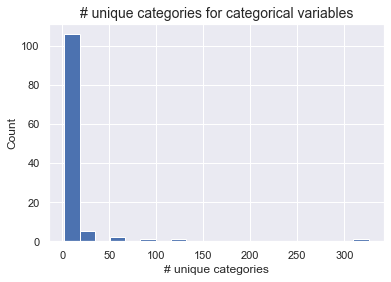

2      72
4      12
3       4
7       4
5       3
8       3
20      2
19      2
17      2
16      2
51      1
15      1
23      1
11      1
13      1
131     1
84      1
9       1
326     1
61      1
Name: unique, dtype: int64


In [13]:
# a majority of the categorical features were binary (had 2 unique categories)
nunique_cat = train.describe(include=['O']).loc['unique']
fig, ax = plt.subplots()
ax.hist(nunique_cat, bins=20)
ax.set(xlabel='# unique categories', ylabel='Count')
ax.set_title('# unique categories for categorical variables', fontsize=14)
plt.show()
if savefig:
    fig.savefig(fig_path+'cat_categories.pdf', format='pdf', bbox_inches='tight')
print(nunique_cat.value_counts())

### Modeling

In [14]:
# get ready for modeling
train = pd.read_csv('train.csv', index_col='id')
X_train = train.drop('loss', axis=1)
y_train = train['loss']
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train: (188318, 130)
y_train: (188318,)


#### Preprocessing pipeline

In [15]:
# build a preprocessing pipeline
# continuous features are already min-max scaled
# one option to use as is, another is to apply standard scaling

# for continuous, apply standard scaling
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# for categorical, apply OneHotEncoder
cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# define preprocessor
if True:
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ], remainder='passthrough')

# define alternative preprocessor, not using standard scaling 
# since numeric features already appear similarly (min-max) scaled
if False:
    preprocessor = ColumnTransformer(transformers=[
        ('cat', cat_transformer, cat_cols),
    ], remainder='passthrough')

# review preprocessing
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['cont1', 'cont2', 'cont3', 'cont4', 'cont5',
                                  'cont6', 'cont7', 'cont8', 'cont9', 'cont10',
                                  'cont11', 'cont12', 'cont13', 'cont14']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['cat1', 'cat2', 'cat3', 'cat4', 'cat5',
                                  'cat6', 'cat7', 'cat8', 'cat9', 'cat10',
                                  'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
                                  'cat16', 'cat17', 'cat18', 'cat19', 'cat20',
                      

#### Check preprocessing pipeline

In [16]:
# define a preprocessing pipeline and apply to get preprocessed X_train
preprocess_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
])
X_train_filt = preprocess_pipe.fit_transform(X_train)
preprocess_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['cont1', 'cont2', 'cont3',
                                                   'cont4', 'cont5', 'cont6',
                                                   'cont7', 'cont8', 'cont9',
                                                   'cont10', 'cont11', 'cont12',
                                                   'cont13', 'cont14']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                        

In [17]:
# workaround function for getting feature names from all transformers
# useful for transformers that do not provide a get_feature_names() method
# source: 
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/
# ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [18]:
# add and verify feature names
X_train_filt = pd.DataFrame(X_train_filt,
                            index=X_train.index,
                            columns=get_feature_names(preprocess_pipe['preprocessor']))
X_train_filt
# consists of transformed continous and categorical variables as expected

/Users/lawrencehuang/opt/anaconda3/envs/msds422/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available


,num__cont1,num__cont2,num__cont3,num__cont4,num__cont5,num__cont6,num__cont7,num__cont8,num__cont9,num__cont10,...,encoder__x115_P,encoder__x115_Q,encoder__x115_R,encoder__x115_S,encoder__x115_T,encoder__x115_U,encoder__x115_V,encoder__x115_W,encoder__x115_X,encoder__x115_Y
id,,,,,,,,,,,,,,,,,,,,,
1,1.238750,-1.260936,-1.540471,1.409553,-0.848538,1.107908,-0.840070,-0.922092,1.023032,1.813218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.870537,1.109451,0.463932,0.578923,1.906010,-0.253457,-0.271142,0.573972,-0.738944,-0.316748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-1.236521,-0.718477,-0.072846,-1.206334,-0.432284,-0.980633,-0.949428,-1.069556,-1.237183,-0.933986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-0.918075,0.234524,0.143849,-0.558452,-0.311730,-0.243577,-0.525875,-0.845049,-0.904033,-0.287266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,-1.175963,-1.675658,0.143849,-0.088079,1.037383,-1.523596,-1.331256,-1.207792,-1.456660,-1.537399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587620,-0.780530,1.344566,0.567735,-0.088079,2.163021,-1.210625,-1.092864,-1.207792,-0.973889,-0.907678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587624,0.073543,0.234524,0.251611,1.472276,1.037383,-0.763253,-0.577027,0.743907,-0.445648,-0.109083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587630,-0.050055,1.344566,1.452022,-1.432500,-0.023881,-0.706680,-0.641280,-1.207792,-0.150976,-0.109083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Model training and nested cross-validation

In [19]:
# modeling strategy:
# use an embedded feature selection method (Lasso)
# add regularlized methods Ridge and ElasticNet for comparison
# perform nested cross-validation: inner CV on hyperparameters 
# then outer CV on models to see how the model generalizes to new data 
# the nested CV will include the model selection process as part of scoring

# define L1 ratios to test for ElasticNet
# from sklearn documentation: a good choice of list of values for l1_ratio is often 
# to put more values close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge) 
l1_ratios = np.concatenate(([0.05], np.arange(0.1, 0.5, 0.1), np.arange(0.5, 1.05, 0.05))).round(2)

# cross-validation
cv=5

In [20]:
# define regressors
regressors = [LassoCV(cv=cv, verbose=1, 
                      n_jobs=-1, random_state=123, selection='random'), 
              RidgeCV(alphas=np.logspace(-5, 3, 100, endpoint=True), 
                      scoring='neg_mean_absolute_error'),
              ElasticNetCV(l1_ratio=l1_ratios, cv=cv, verbose=1, 
                           n_jobs=-1, random_state=123, selection='random'),
             ]

for regressor in regressors:
    print('\n', regressor)
    
    # inner cv on hyperparams
    # use TransformedTargetRegressor to apply log transformation to the target
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1))
    ])
    
    # outer cv on model
    cv_scores = cross_validate(pipeline, X_train, y_train,
                               scoring=['neg_mean_absolute_error', 'r2'], 
                               cv=cv, verbose=1, return_train_score=True, n_jobs=None)

    # mean metrics
    print('mean train r2 = {:.2f}'.format(cv_scores['train_r2'].mean()))
    print('mean test r2 = {:.2f}'.format(cv_scores['test_r2'].mean()))
#     print('\ntrain MAE = {}'.format(-cv_scores['train_neg_mean_absolute_error'].round(2)))
    print('mean train MAE = {:.2f}'.format((-cv_scores['train_neg_mean_absolute_error']).mean()))
#     print('test MAE = {}'.format(-cv_scores['test_neg_mean_absolute_error'].round(2)))
    print('mean test MAE = {:.2f}'.format((-cv_scores['test_neg_mean_absolute_error']).mean()))


 LassoCV(cv=5, n_jobs=-1, random_state=123, selection='random', verbose=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.4s remaining:   33.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.3s remaining:   36.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished
/Users/lawrencehuang/opt/anaconda3/envs/msds422/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

mean train r2 = 0.42
mean test r2 = 0.41
mean train MAE = 1246.13
mean test MAE = 1248.79

 RidgeCV(alphas=array([1.00000000e-05, 1.20450354e-05, 1.45082878e-05, 1.74752840e-05,
       2.10490414e-05, 2.53536449e-05, 3.05385551e-05, 3.67837977e-05,
       4.43062146e-05, 5.33669923e-05, 6.42807312e-05, 7.74263683e-05,
       9.32603347e-05, 1.12332403e-04, 1.35304777e-04, 1.62975083e-04,
       1.96304065e-04, 2.36448941e-04, 2.84803587e-04, 3.43046929e-04,
       4.13201240e-04, 4.97702356e-0...
       1.38488637e+01, 1.66810054e+01, 2.00923300e+01, 2.42012826e+01,
       2.91505306e+01, 3.51119173e+01, 4.22924287e+01, 5.09413801e+01,
       6.13590727e+01, 7.39072203e+01, 8.90215085e+01, 1.07226722e+02,
       1.29154967e+02, 1.55567614e+02, 1.87381742e+02, 2.25701972e+02,
       2.71858824e+02, 3.27454916e+02, 3.94420606e+02, 4.75081016e+02,
       5.72236766e+02, 6.89261210e+02, 8.30217568e+02, 1.00000000e+03]),
        scoring='neg_mean_absolute_error')


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


mean train r2 = 0.44
mean test r2 = 0.43
mean train MAE = 1240.78
mean test MAE = 1246.82

 ElasticNetCV(cv=5,
             l1_ratio=array([0.05, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75,
       0.8 , 0.85, 0.9 , 0.95, 1.  ]),
             n_jobs=-1, random_state=123, selection='random', verbose=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.5min finished
/Users/lawrencehuang/opt/anaconda3/envs/msds422/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.748631207985454, tolerance: 9.902325778003364
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

mean train r2 = 0.42
mean test r2 = 0.41
mean train MAE = 1246.13
mean test MAE = 1248.79


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 38.2min finished


In [21]:
# train models on entire training data; get model that could be used for predictions
# define regressors
regressors = [LassoCV(cv=cv, verbose=0, 
                      n_jobs=-1, random_state=123, selection='random'), 
              RidgeCV(alphas=np.logspace(-5, 3, 100, endpoint=True), 
                      scoring='neg_mean_absolute_error'),
              ElasticNetCV(l1_ratio=l1_ratios, cv=cv, verbose=0, 
                           n_jobs=-1, random_state=123, selection='random'),
             ]

for regressor in regressors:
    print('\n', regressor)
    
    # cv on hyperparams
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1))
    ])
    
    pipeline.fit(X_train, y_train)
    
    if str(regressor).split('(')[0] == 'LassoCV':
        pipeline_lasso = pipeline
    elif str(regressor).split('(')[0] == 'RidgeCV':
        pipeline_ridge = pipeline
    elif str(regressor).split('(')[0] == 'ElasticNetCV':
        pipeline_elasticnet = pipeline


 LassoCV(cv=5, n_jobs=-1, random_state=123, selection='random', verbose=0)

 RidgeCV(alphas=array([1.00000000e-05, 1.20450354e-05, 1.45082878e-05, 1.74752840e-05,
       2.10490414e-05, 2.53536449e-05, 3.05385551e-05, 3.67837977e-05,
       4.43062146e-05, 5.33669923e-05, 6.42807312e-05, 7.74263683e-05,
       9.32603347e-05, 1.12332403e-04, 1.35304777e-04, 1.62975083e-04,
       1.96304065e-04, 2.36448941e-04, 2.84803587e-04, 3.43046929e-04,
       4.13201240e-04, 4.97702356e-0...
       1.38488637e+01, 1.66810054e+01, 2.00923300e+01, 2.42012826e+01,
       2.91505306e+01, 3.51119173e+01, 4.22924287e+01, 5.09413801e+01,
       6.13590727e+01, 7.39072203e+01, 8.90215085e+01, 1.07226722e+02,
       1.29154967e+02, 1.55567614e+02, 1.87381742e+02, 2.25701972e+02,
       2.71858824e+02, 3.27454916e+02, 3.94420606e+02, 4.75081016e+02,
       5.72236766e+02, 6.89261210e+02, 8.30217568e+02, 1.00000000e+03]),
        scoring='neg_mean_absolute_error')

 ElasticNetCV(cv=5,
             l1_rati

### Review results, evaluate models

In [22]:
# best model params
# Lasso: alpha chosen by cross-validation
print('\nLasso')
print('alpha = {:.2e}'.format(pipeline_lasso['model'].regressor_.alpha_))

# Ridge: estimated alpha 
print('\nRidge')
print('alpha = {:.2f}'.format(pipeline_ridge['model'].regressor_.alpha_))

# ElasticNet: alpha and l1_ratio chosen by cross-validation
print('\nElasticNet')
print('alpha = {:.2e}'.format(pipeline_elasticnet['model'].regressor_.alpha_))
print('l1_ratio =', pipeline_elasticnet['model'].regressor_.l1_ratio_)


Lasso
alpha = 1.72e-04

Ridge
alpha = 13.85

ElasticNet
alpha = 1.72e-04
l1_ratio = 1.0


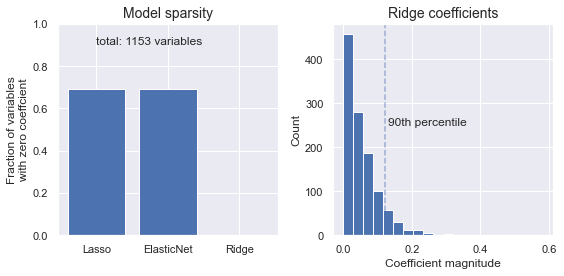

In [23]:
# examine fraction of variables with zero coefficients
# and examine coefficients from Ridge
zero_coef = [np.mean(pipeline_lasso['model'].regressor_.coef_==0),
             np.mean(pipeline_elasticnet['model'].regressor_.coef_==0),
             np.mean(pipeline_ridge['model'].regressor_.coef_==0),
            ]
coef_thr = 90
coef_cutoff_ridge = np.percentile(np.abs(pipeline_ridge['model'].regressor_.coef_), coef_thr)
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].bar(x=['Lasso', 'ElasticNet', 'Ridge'],
       height=zero_coef)
axs[0].set_ylabel('Fraction of variables\nwith zero coeffcient')
axs[0].set_ylim([0, 1])
axs[0].text(0, 0.9, 'total: {} variables'.format(len(pipeline_lasso['model'].regressor_.coef_)))
axs[0].set_title('Model sparsity', fontsize=14)
axs[1].hist(np.abs(pipeline_ridge['model'].regressor_.coef_), bins=20)
axs[1].axvline(coef_cutoff_ridge, ls='--', alpha=0.5)
axs[1].text(coef_cutoff_ridge+0.01, 250, f'{coef_thr}th percentile')
axs[1].set(xlabel='Coefficient magnitude', ylabel='Count')
axs[1].set_title('Ridge coefficients', fontsize=14)
fig.tight_layout()
plt.show()
if savefig:
    fig.savefig(fig_path+'model_sparsity.pdf', format='pdf')

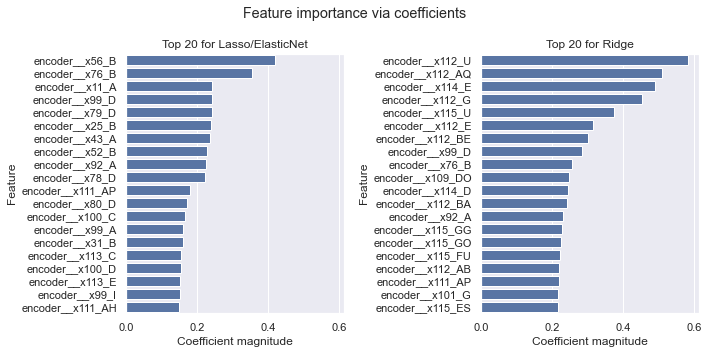

In [24]:
# feature importance via coefficients
# get feature names from transformed X_train using the same preprocessing pipeline
feature_names = X_train_filt.columns
# get coef magnitude
lasso_importance = pd.DataFrame({'Feature':feature_names, 
                                 'Coefficient':np.abs(pipeline_lasso['model'].regressor_.coef_)})\
.sort_values(by='Coefficient', ascending=False)[:20]

ridge_importance = pd.DataFrame({'Feature':feature_names, 
                                 'Coefficient':np.abs(pipeline_ridge['model'].regressor_.coef_)})\
.sort_values(by='Coefficient', ascending=False)[:20]

fig, axs = plt.subplots(1,2, figsize=(10, 5), sharex=True)
sns.barplot(x='Coefficient', y='Feature', data=lasso_importance, color='#4C72B0', ax=axs[0])
sns.barplot(x='Coefficient', y='Feature', data=ridge_importance, color='#4C72B0', ax=axs[1])
axs[0].set_title('Top 20 for Lasso/ElasticNet')
axs[1].set_title('Top 20 for Ridge')
for ax in axs:
    ax.set_xlabel('Coefficient magnitude')
fig.tight_layout()
plt.suptitle('Feature importance via coefficients')
plt.subplots_adjust(top=0.85)
plt.show()
if savefig:
    fig.savefig(fig_path+'feat_importance.pdf', format='pdf')

### Export results for Kaggle submission

In [25]:
# load test data and sample submission
test = pd.read_csv('test.csv', index_col='id')
sample_submission = pd.read_csv('sample_submission.csv', index_col='id')
print('test shape:', test.shape)
print('sample submission shape:', sample_submission.shape)
sample_submission.head()

test shape: (125546, 130)
sample submission shape: (125546, 1)


,loss
id,
4,0
6,0
9,0
12,0
15,0


In [26]:
# get predictions
y_pred_lasso = pipeline_lasso.predict(test) # lasso
y_pred_ridge = pipeline_ridge.predict(test) # ridge
y_pred_mean = (y_pred_lasso+y_pred_ridge)/2 # mean

In [27]:
# save predictions
# lasso
submission_l = sample_submission.copy()
submission_l['loss'] = y_pred_lasso
submission_l.to_csv('result_l.csv')

# ridge
submission_r = sample_submission.copy()
submission_r['loss'] = y_pred_ridge
submission_r.to_csv('result_r.csv')

# mean
submission_m = sample_submission.copy()
submission_m['loss'] = y_pred_mean
submission_m.to_csv('result_m.csv')